In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

# ICIAR Challenge: BreAst Cancer Histology Images

This is the dataset: https://rdm.inesctec.pt/dataset/nis-2017-003

This is a paper: http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0177544


DATA CITATION: Teresa Araújo, Guilherme Aresta, Eduardo Castro, José Rouco, Paulo Aguiar, Catarina Eloy, António Polónia, and Aurélio Campilho, Classification of Breast Cancer Histology Images Using Convolutional Neural Networks, PLOS ONE, 2017.

Challenge description from https://iciar2018-challenge.grand-challenge.org/dataset/
(though dataset for challenge was augmented; I used the original open dataset because I have access)

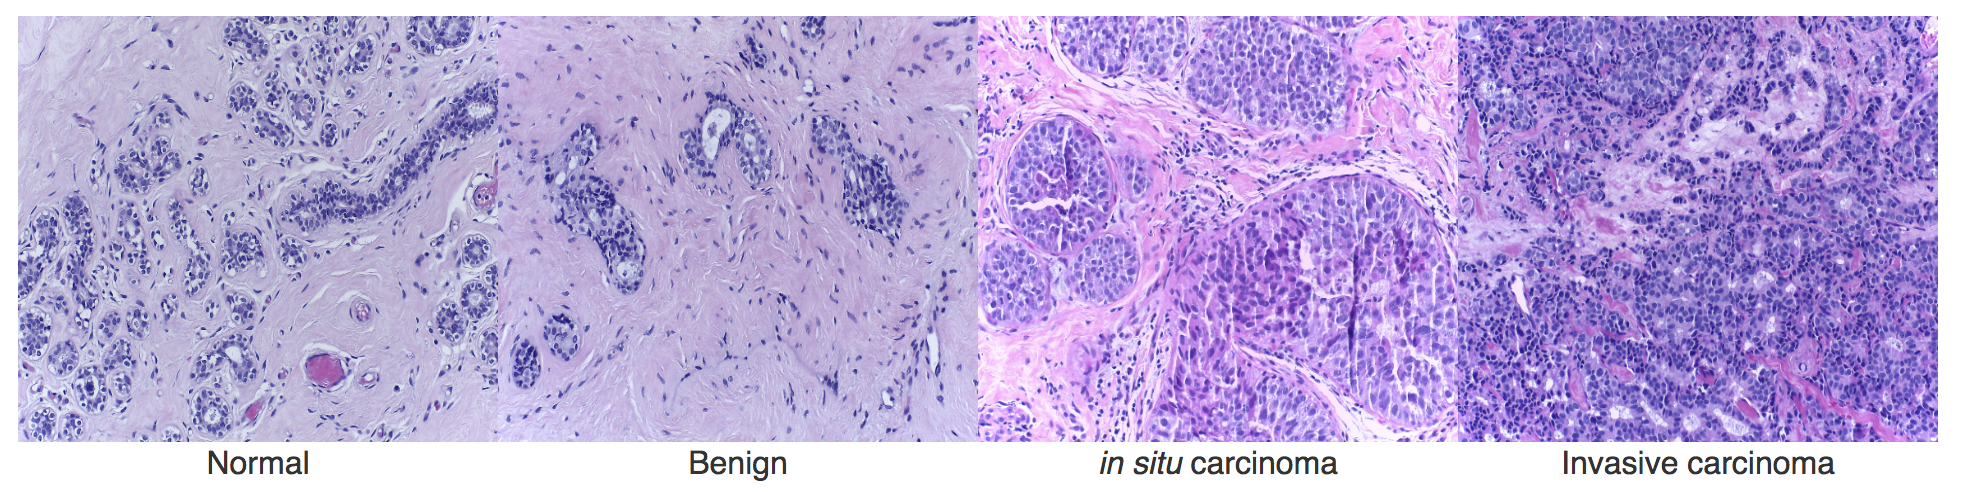

In [2]:
Image('bach_info.png')

NOTE: While the example looks straightforward, the variation is considerable and I don't think I would be a good human classifier after a few days. From the paper:

"The features extracted by the CNN are also used for training a Support Vector Machine classifier. Accuracies of 77.8% for four class and 83.3% for carcinoma/non-carcinoma are achieved. The sensitivity of our method for cancer cases is 95.6%."

## Data Description

https://iciar2018-challenge.grand-challenge.org/dataset/

The larger dataset contains a total of 400 microscopy images, distributed as follows:

- Normal: 100
- Benign: 100
- in situ carcinoma: 100
- Invasive carcinoma: 100

The smaller one has 55 total images... that's what we downloaded

# MY APPROACH

Goal: create an image processing pipeline that extracts features capable of classifying breast cancer histology.

My Approach

- use the watershed segmentation to set the boundaries between cells
- use DBSCAN to identify clusters of nuclei that are touching
- Template matching doesn't work well because it's just little black dots... instead extract features from the watershed and DBSCAN outputs and use those to classify

# Import packages, set paths

In [3]:
import pandas as pd
import os
from glob import glob
import numpy as np
import seaborn as sns
import pickle

from IPython.display import Image
from matplotlib.pyplot import imread, imshow, subplot
import matplotlib.pyplot as plt

#OpenCV
import cv2

from skimage import exposure, util
from skimage.color import rgb2gray
from skimage.filters.thresholding import threshold_otsu, threshold_yen

import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN

In [4]:
basepath = '../../data/ICIAR2018_BACH/breasthistology/'

trainpath_normal = glob(os.path.join(basepath, '*Train*/*Normal*'))[0]
testpath = glob(os.path.join(basepath, '*Test*'))[0]
test_label_file = glob(os.path.join(testpath, '*labels*'))[0]
test_labels = pd.read_csv(test_label_file, delimiter='\t', header=None)

trainsets = glob(trainpath_normal+'/*')
testsets = glob(testpath+'/*.tif')
all_trainsets = glob(os.path.join(basepath, '*Train*/*/*.tif'))

print('Normal Training Images N=%i' % len(trainsets))
print('All Training Images N=%i' % len(all_trainsets))
print('Testing Images N=%i' % len(testsets))

Normal Training Images N=55
All Training Images N=249
Testing Images N=36


In [5]:
case1 = trainsets[0]
trainsets[0]

'../../data/ICIAR2018_BACH/breasthistology/Training_data/Normal/t48.tif'

# Look at the data

To look at all of the masks together, we need to aggregate them

(1536, 2048, 3)


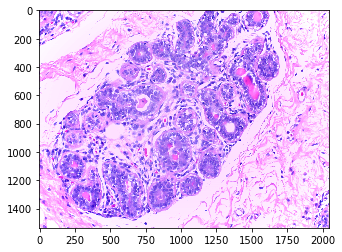

In [6]:
case1_im = imread(glob(case1)[0])
print(case1_im.shape)
imshow(case1_im)

looks like our images have several channels... let's take a look

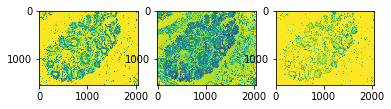

In [7]:
for i in range(case1_im.shape[-1]):
    subplot(1,case1_im.shape[-1],i+1)
    imshow(case1_im[:,:,i])

# PART I: SEGMENT ALL NUCLEI FROM BACKGROUND
This will result in a binary image that indicates nucleus (true) from background (false). This will go into PART II, which separates individual overlapping nuclei from each other.

# Preprocessing

- Grayscale if the first 3 channels are the same (RBG) 
- If there's a 4th channel, it's probably the alpha channel, which provides transparency information to render on a background. We aren't interested in this channel so let's get rid of it.

In [8]:
if case1_im.shape[-1]==4:
    case1_im = np.delete(case1_im,3,2)
    print("getting rid of alpha channel")
if np.array_equal(case1_im[:,:,0],case1_im[:,:,1]):
    print("Grayscale")
assert(case1_im.shape[-1])==3
case1_im.shape

(1536, 2048, 3)

## Now let's separate the stains based via color deconvolution

In [9]:
#CITE: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html

import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap

def stainsep(im, show=False):
    # Create an artificial color close to the orginal one
    cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
    cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white',
                                                 'saddlebrown'])
    cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet',
                                                   'white'])

    ihc_hed = rgb2hed(im)

    if show:
            
        fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(im)
        ax[0].set_title("Original image")

        ax[1].imshow(ihc_hed[:, :, 0], cmap=cmap_hema)
        ax[1].set_title("Hematoxylin")

        ax[2].imshow(ihc_hed[:, :, 1], cmap=cmap_eosin)
        ax[2].set_title("Eosin")

        ax[3].imshow(ihc_hed[:, :, 2], cmap=cmap_dab)
        ax[3].set_title("DAB")

        for a in ax.ravel():
            a.axis('off')

        fig.tight_layout()
    return ihc_hed

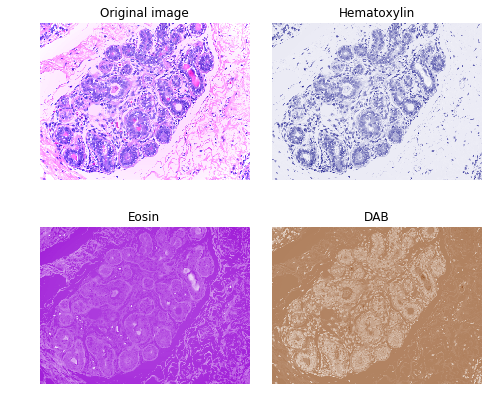

In [10]:
case1_deco = stainsep(case1_im, show=True)

## Let's try equalizing the histogram. 

This shows the channels equalized individually, which might be useful to consider

In [11]:
def show_histeq_by_channel(im):
    f = plt.figure(figsize=(10,10))
    lastdim = im.shape[-1]
    newim = im.copy()
    for i in range(lastdim):
        f.add_subplot(4,lastdim,i+1)
        imshow(im[:,:,i]*1)
        f.add_subplot(4,lastdim,i+1+lastdim)
        flat = np.ndarray.flatten(im[:,:,i])
        sns.distplot(flat)
        #normalize histogram
        img_adapteq = exposure.equalize_adapthist(
            im[:,:,i], clip_limit=0.03)
        f.add_subplot(4,lastdim,i+1+lastdim*2)
        imshow(img_adapteq)
        f.add_subplot(4,lastdim,i+1+lastdim*3)
        sns.distplot(np.ndarray.flatten(img_adapteq))
        newim[:,:,i] = img_adapteq
    return newim
    

By RBG

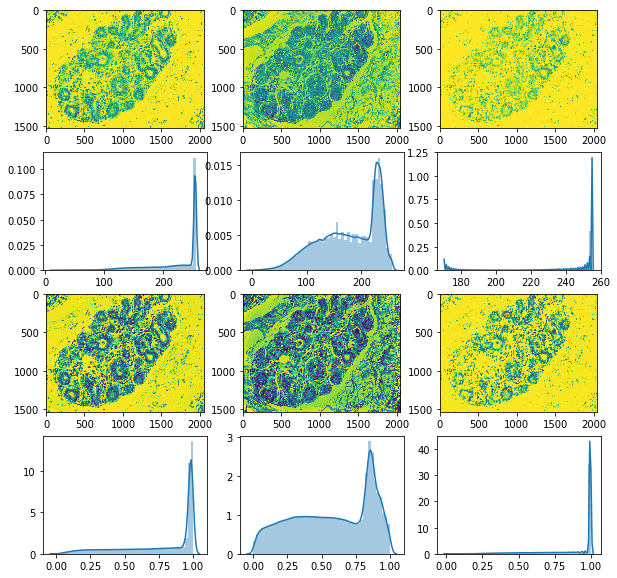

In [12]:
test = show_histeq_by_channel(case1_im)

By deconvolved color channel doesn't work because of negatives; need to invert

In [13]:
def show_hist_by_channel(im):
    f = plt.figure(figsize=(10,10))
    lastdim = im.shape[-1]
    newim = im.copy()
    for i in range(lastdim):
        f.add_subplot(2,lastdim,i+1)
        imshow(im[:,:,i]*1)
        f.add_subplot(2,lastdim,i+1+lastdim)
        flat = np.ndarray.flatten(im[:,:,i])
        sns.distplot(flat)

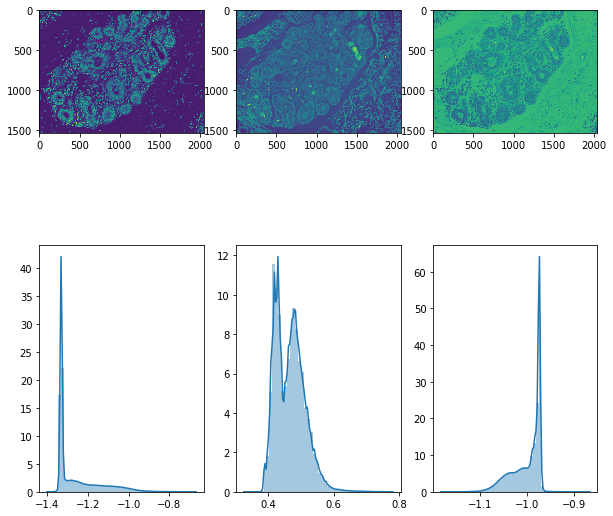

In [14]:
test = show_hist_by_channel(case1_deco)

In [15]:
def invert_negch(im):
    newim = np.zeros(im.shape)
    for i in range(im.shape[-1]):
        if im[:,:,i].mean()<0:
            newim[:,:,i] = util.invert(im[:,:,i])
        else:
            newim[:,:,i] = im[:,:,i]
    return newim

In [16]:
case1_deco_inv = invert_negch(case1_deco)

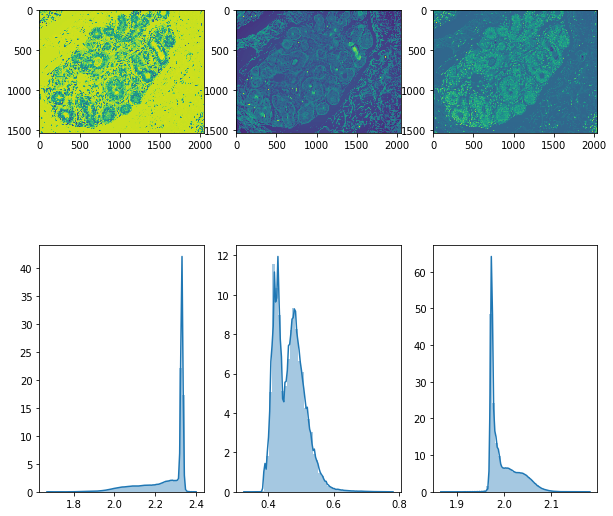

In [17]:
show_hist_by_channel(case1_deco_inv)

NOTE: for RGB implementation need to convert to YCbCr, perform histogram equalization on the intensity plane (Y) and convert back to RGB.

In [18]:
def histeq_rgb(rgb_im):
    imgYCR = cv2.cvtColor(rgb_im, cv2.COLOR_RGB2YCR_CB) #check this with an RGB; is is BGR or RGB?
    imgYCR[:,:,0] = exposure.equalize_adapthist(imgYCR[:,:,0], clip_limit=0.03)
    img_adapteq = cv2.cvtColor(imgYCR, cv2.COLOR_YCR_CB2RGB)
    return img_adapteq

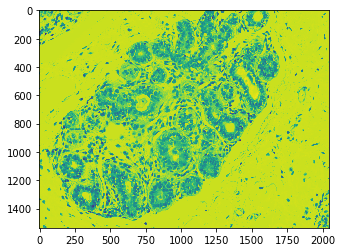

In [19]:
imshow(util.invert(case1_deco[:,:,0]))

In [20]:
def reduce_to_one_channel(im):
    return cv2.cvtColor(im, cv2.COLOR_RGB2YCR_CB)[:,:,0]

def get_hema(im):
    return util.invert(rgb2hed(im)[:,:,0])

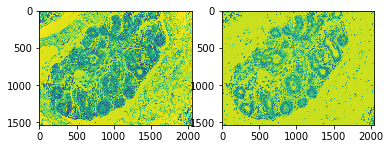

In [21]:
subplot(1,2,1)
imshow(reduce_to_one_channel(case1_im))
subplot(1,2,2)
imshow(get_hema(case1_im))

## Now put together the preprocessing

In [22]:
def preproc(image_path, show=False, hema=True, histeq=False, force_blackbg=False, grayscale=False):
    im = imread(image_path)
    orig = im.copy()
    if im.shape[-1] == 4:
        im = np.delete(im,3,2)
    assert(len(im.shape)==3)
    assert(im.shape[-1])==3
    if force_blackbg:
        nphist = np.histogram(im, bins=10)[0]
        if sum(nphist[:5])<sum(nphist[5:]):
            #print('Flipping white background to black')
            im = util.invert(im)
    if hema:
        im = get_hema(im)
    if histeq:
        im = histeq_rgb(im)
    if grayscale:
        im = rgb2gray(im)
    if show:
        subplot(2,3,1)
        imshow(orig)
        plt.title('Original')
        subplot(2,3,2)
        imshow(get_hema(orig))
        plt.title('Hema')
        subplot(2,3,3)
        imshow(rgb2gray(orig))
        plt.title('Grayscale')
        subplot(2,3,4)
        sns.distplot(np.ndarray.flatten(orig))
        subplot(2,3,5)
        sns.distplot(np.ndarray.flatten(im))
        subplot(2,3,6)
        sns.distplot(np.ndarray.flatten(rgb2gray(orig)))
    return im

Now you can take a look at any of the images by changing the index of trainsets

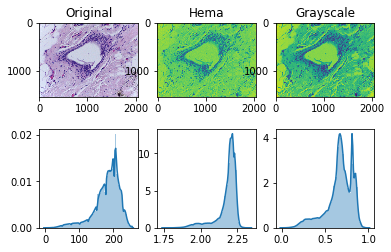

In [23]:
N_test = 10
test = preproc(trainsets[N_test], show=True)

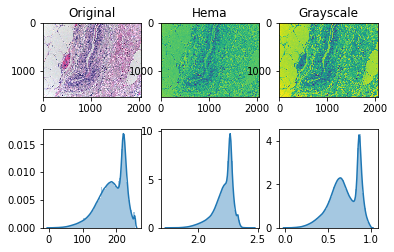

In [24]:
test2 = preproc(trainsets[1], show=True)

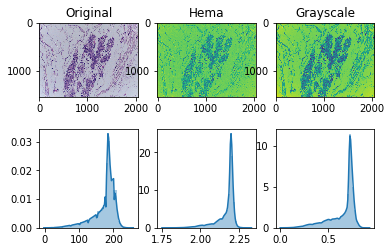

In [25]:
test3 = preproc(trainsets[5], show=True)

we may not want to equalize the histograms if circular objects of a certain contrast are already segmentable

# Apply a Threshold

We don't have a ground-truth for this dataset so by eye is how we'll evaluate for now

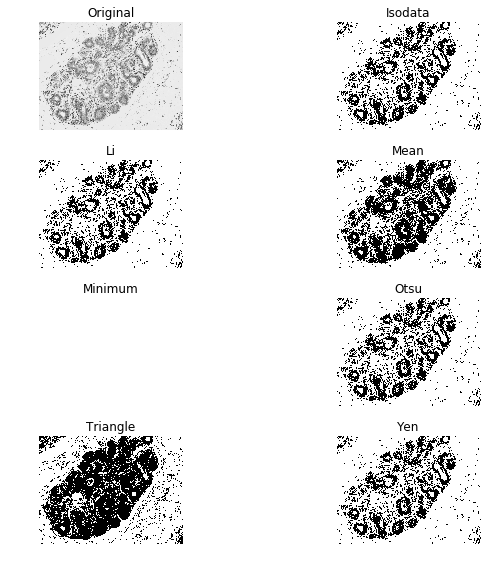

In [26]:
#Plot adapted from skimage example
#CITE: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html#sphx-glr-auto-examples-segmentation-plot-thresholding-py
from skimage.filters import try_all_threshold

img = get_hema(case1_im)

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

Median otsu seems good for Normal... will go back and test on the other classes

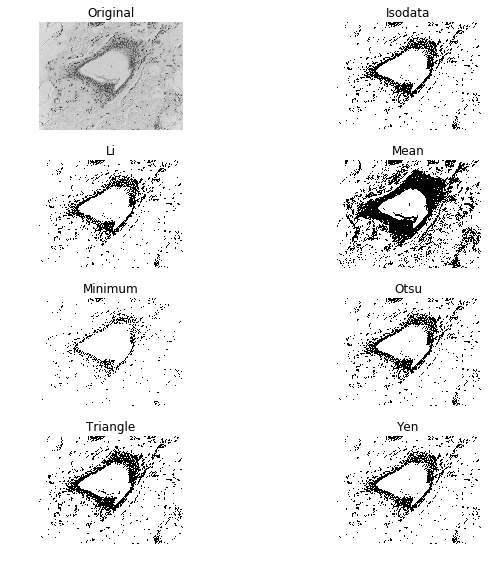

In [27]:
fig, ax = try_all_threshold(test, figsize=(10, 8), verbose=False)
plt.show()

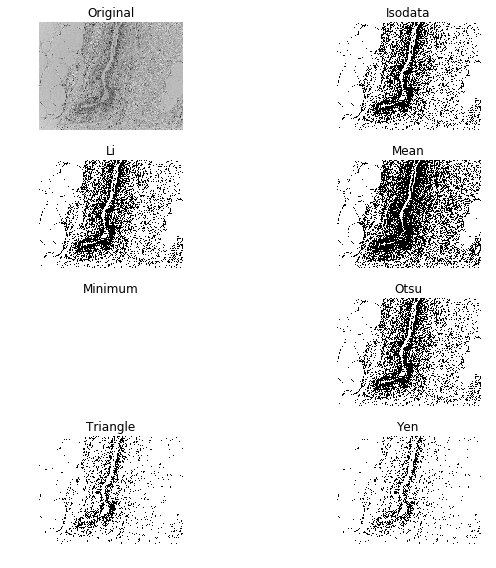

In [28]:
fig, ax = try_all_threshold(test2, figsize=(10, 8), verbose=False)
plt.show()

Future improvement: use texture analysis to identify which segmentations should use Yen

Do a cross-validation on the classifier to see which thresolding method is the best at distinguishing the cancer stages

## Knobs that matter: 

- Definitely use color deconvolution
- Equalize the histogram or don't
- threshold method choice depends on this

TODO: Optimize the choice of thresholding method on the training set

## Future improvement: UPDATE: did this on H&E stains
If we knew or could detect the staining of each image we could use color deconvolution and pick the one that represents the nucleus (Example, below)

http://www.cureffi.org/2012/05/13/color-transformations-for-segmenting-complex-images/

http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_ihc_color_separation.html

# PART II: Segmentation of Mask

We take the output of our thresholding and now need to separate cells into individual units for quantification

In [29]:
#set colormap for id
cmap = plt.cm.hsv
cmap.set_under(color='black')  

cmap_prism = plt.cm.prism
cmap_prism.set_under(color='black')

## Watershed-based algorithm for segmentation

http://scikit-image.org/docs/stable/auto_examples/segmentation/plot_compact_watershed.html#sphx-glr-auto-examples-segmentation-plot-compact-watershed-py

In [30]:
#Adapted code from skimage example: watershed segmentation
#CITE: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

#IMPLEMENTATION FROM GALA (NOT IMPLEMENTED IN SKIMAGE)
#CITE: https://gala.readthedocs.io/en/latest/installation.html
#INSTALLATION PROBLEMS SO HAD TO COPY DIRECTLY IN

from scipy.ndimage import grey_dilation, generate_binary_structure

def morphological_reconstruction(marker, mask, connectivity=1):
    """FROM GALA"""
    sel = generate_binary_structure(marker.ndim, connectivity)
    diff = True
    while diff:
        markernew = grey_dilation(marker, footprint=sel)
        markernew = np.minimum(markernew, mask)
        diff = (markernew-marker).max() > 0
        marker = markernew
    return marker

def hminima(a, thresh):
    """FROM GALA"""
    maxval = a.max()
    ainv = maxval-a
    return maxval - morphological_reconstruction(ainv-thresh, ainv)

In [31]:
#Adapted code from skimage example: watershed segmentation and some functions from GALA that weren't implemented
#CITE: http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
#CITE: CITE: https://gala.readthedocs.io/en/latest/installation.html

def dowatershedseg(image, show=False, hminthresh=2):
    distance = ndi.distance_transform_edt(image)
    origdist = distance.copy()
    #sns.kdeplot(np.ndarray.flatten(distance[distance>0]))
    
    #OVERSEGMENTATION WITHTOUT THIS... SCIKIT IMAGE DOESN'T HAVE H-MINIMA TRANSFORM IMPLEMENTED
    #HMINTHRESH SHOULD BE PRIMARY METRIC FOR TUNING
    distance = util.invert(hminima(util.invert(distance), hminthresh))
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                                labels=image)
    distance = -distance #creates catchement basins
    markers = ndi.label(local_maxi)[0]
    labels = watershed(distance, markers, mask=image)
    if show:
        cmap = plt.cm.hsv
        cmap.set_under(color='black') 
        fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
        ax[0].set_title('Overlapping objects')
        ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
        ax[1].set_title('Distances')
        ax[2].imshow(local_maxi, cmap=plt.cm.gray, interpolation='nearest')
        ax[2].set_title('Local Maxima')
        ax[3].imshow(labels, cmap=cmap_prism, interpolation='nearest', vmin=0.000001)
        ax[3].set_title('Separated objects')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    return labels

Let's try the segmentation on the median otsu mask... 

In [32]:
from skimage.filters.thresholding import threshold_otsu

def apply_otsu(im):
    thr = threshold_otsu(im)
    imthr = im>thr
    counts, bins = np.histogram(imthr, bins=2)
    if counts[0]<counts[1]:
        print('inverting')
        return im<thr
    else:
        return imthr

In [33]:
case1_mask = apply_otsu(get_hema(case1_im))
test_mask = apply_otsu(test)
test2_mask = apply_otsu(test2)
test3_mask = apply_otsu(test3)

inverting
inverting
inverting
inverting


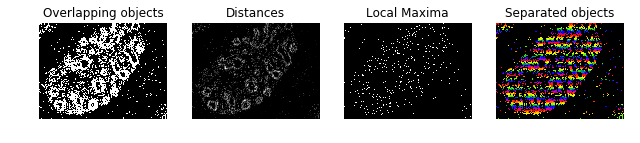

In [34]:
labels = dowatershedseg(case1_mask, show=True)

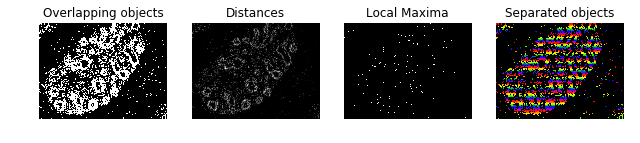

In [35]:
labels_nohmin = dowatershedseg(case1_mask, hminthresh=0, show=True)

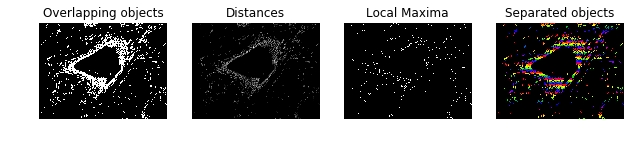

In [36]:
labels1 = dowatershedseg(test_mask, show=True)

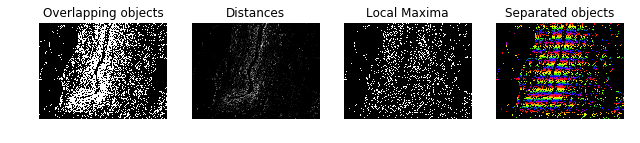

In [37]:
labels2 = dowatershedseg(test2_mask, show=True)

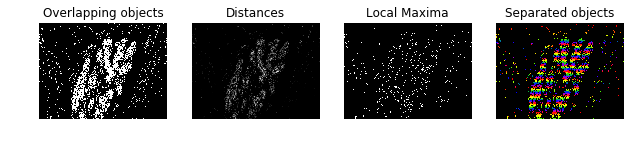

In [38]:
labels3 = dowatershedseg(test3_mask, show=True)

### First let's get rough cluster labels with DBSCAN

In [39]:
#right now ncl = int(labels.max()/4)
def docluster(im, alg='dbscan'):
    coords = np.where(im>0)
    coordarray = np.zeros([coords[0].shape[0],2])
    coordarray[:,0] = coords[0]
    coordarray[:,1] = coords[1]
    
    #later will use something more optimal like DBSCAN but for now kmeans
    if alg is 'kmeans':
        ncl=int(labels.max()/2)
        y_pred = cluster.KMeans(n_clusters=ncl).fit_predict(coordarray)
    elif alg is 'dbscan':
        db = DBSCAN(eps=1, min_samples=1).fit(coordarray)
        y_pred = db.labels_.astype(np.int)
    cluster_im = np.zeros(im.shape)
    for i in range(y_pred.shape[0]):
        x,y = coordarray[i,:]
        cluster_im[int(x),int(y)] = y_pred[i]
    return cluster_im

In [40]:
coords = np.where(case1_mask>0)
coordarray = np.zeros([coords[0].shape[0],2])
coordarray[:,0] = coords[0]
coordarray[:,1] = coords[1]

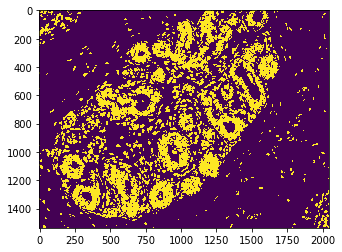

In [41]:
imshow(case1_mask)

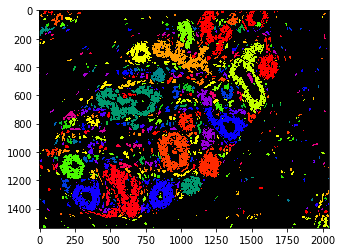

In [42]:
db_im = docluster(case1_mask, alg='dbscan')
imshow(db_im, cmap=cmap_prism, vmin=0.01)

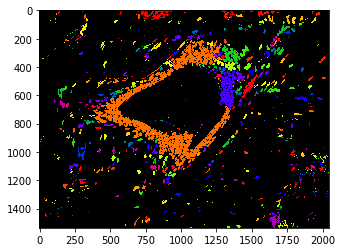

In [43]:
db_im_t = docluster(test_mask, alg='dbscan')
imshow(db_im_t, cmap=cmap_prism, vmin=0.01)

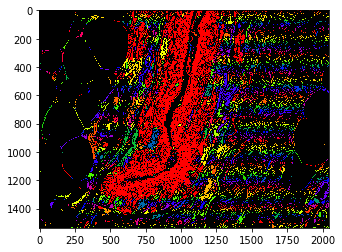

In [44]:
db_im_t2 = docluster(test2_mask, alg='dbscan')
imshow(db_im_t2, cmap=cmap_prism, vmin=0.01)

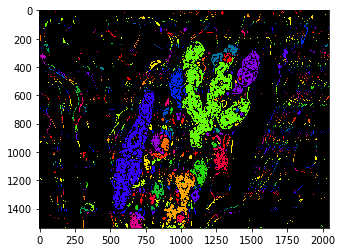

In [45]:
db_im_t3 = docluster(test3_mask, alg='dbscan')
imshow(db_im_t3, cmap=cmap_prism, vmin=0.01)

## NOTE: the clusters of cells segmented by DBSCAN may be useful in classifying the slides

Features:

- DBSCAN cluster size histogram
- Watershed cluster size histogram
- Filter cluster size histogram
- Difference between # clusters DBscan vs filter
- Number of agreement cells
- Network metrics using euclidean distance as weights

### Now let's look at the sizes of the blobs

In [46]:
def calc_blobsize(im, nbins):
    watershed_sizes = np.histogram(labels, bins=labels.max())[0]

Text(0.5,1,'DBSCAN')

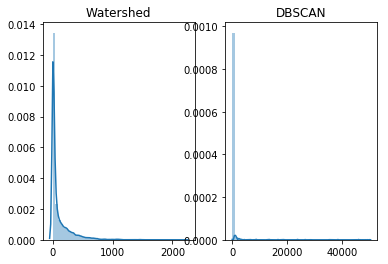

In [47]:
watershed_sizes = np.histogram(labels, bins=labels.max())[0]
db_sizes = np.histogram(db_im, bins=int(labels.max()/2))[0]
xmax = max(watershed_sizes[1:].max(),db_sizes[1:].max())

subplot(1,2,1)
sns.distplot(watershed_sizes[1:]) #first is background
plt.title('Watershed')
#plt.xlim(0,xmax)

subplot(1,2,2)
sns.distplot(db_sizes[1:]) #first is background
plt.title('DBSCAN')
#plt.xlim(0,xmax)

THOUGHT: to compare these, let's assign the pixel value to the size of the blob it belongs to; then we can just compare the images

In [48]:
def getcountim(im, background=0):
    counts_im = np.zeros(im.shape)
    for i in np.unique(im):
        if i==0:
            counts_im[im==i] = background
        else:
            counts_im[im==i] = sum(sum(im==i) )
    return counts_im

Text(0.5,1,'watershed cluster size')

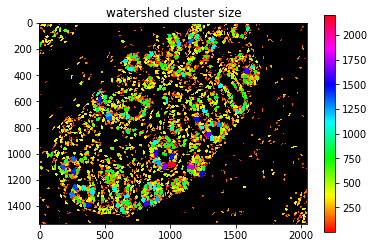

In [49]:
imshow(getcountim(labels), cmap=cmap, vmin=0.001)
plt.colorbar()
plt.title('watershed cluster size')

Text(0.5,1,'watershed cluster size')

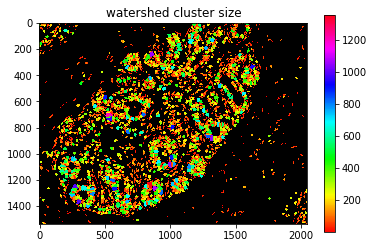

In [50]:
imshow(getcountim(labels_nohmin), cmap=cmap, vmin=0.001)
plt.colorbar()
plt.title('watershed cluster size')

The largest watershed segmentations are the best segmentations

Text(0.5,1,'DBSCAN cluster size')

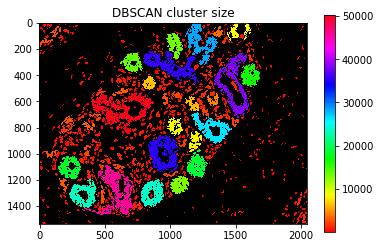

In [51]:
imshow(getcountim(db_im), cmap=cmap, vmin=0.001)
plt.colorbar()
plt.title('DBSCAN cluster size')

In [52]:
def compare_segmentations(seg1,seg2,show=False, title1='seg1', title2='seg2'):
    
    counts_seg1 = getcountim(seg1)
    counts_seg2 = getcountim(seg2)
    agreement = np.logical_and(counts_seg1 > 0, counts_seg2 == counts_seg1)
    
    if show:
        fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
        ax = axes.ravel()

        ax[0].imshow(counts_seg1, cmap=cmap, vmin=0.001)
        ax[0].set_title('%s cluster size' % title1)
        ax[1].imshow(counts_seg2, cmap=cmap, vmin=0.001)
        ax[1].set_title('%s cluster size' % title2)
        ax[2].imshow(agreement, cmap=cmap, vmin=0.001)
        ax[2].set_title('Agreement')

        for a in ax:
            a.set_axis_off()

        fig.tight_layout()
        plt.show()
    return agreement

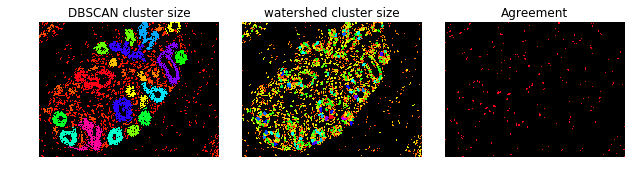

In [53]:
case1_agree = compare_segmentations(db_im, labels, show=True, title1='DBSCAN',title2='watershed')

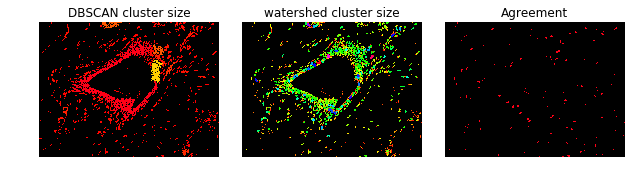

In [54]:
test_agree = compare_segmentations(db_im_t, labels1, show=True, title1='DBSCAN',title2='watershed')

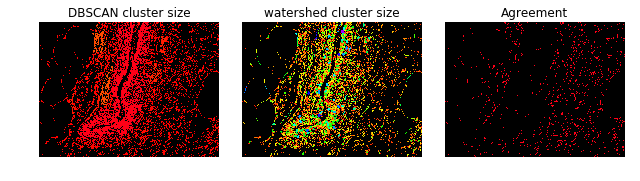

In [55]:
test2_agree = compare_segmentations(db_im_t2, labels2, show=True, title1='DBSCAN',title2='watershed')

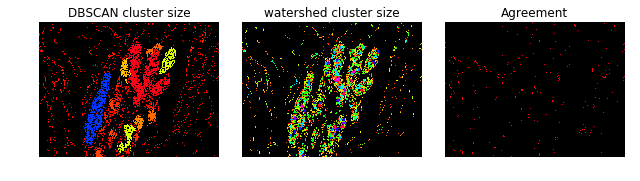

In [56]:
test3_agree = compare_segmentations(db_im_t3, labels3, show=True, title1='DBSCAN',title2='watershed')

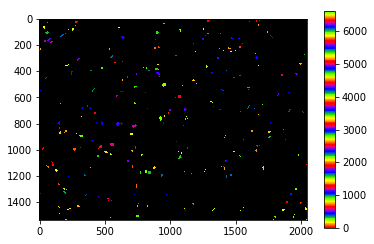

In [57]:
agreement_labels = labels*case1_agree
imshow(agreement_labels, cmap=cmap_prism,vmin=0.0000001)
plt.colorbar()

In [58]:
#Put Part II together into a single function
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
def segment_nuclei(im, templateN=0, cmap=cmap_hema, show=False): #templateN is for debugging (test patches)
    #we need the image for the patches
    if len(im.shape) == 2:
        im_1ch = im
    else:
        im_1ch = get_hema(im)
    imshow(im_1ch)
    #Segmentation
    mask = apply_otsu(im_1ch)
    
    #calculate the watershed segmentation on the mask 
    labels = dowatershedseg(mask)

    #calculate the dbscan segmentation on the mask
    cluster_im = docluster(mask, alg='dbscan')
    
    return labels, cluster_im

In [59]:
#case1_part2 = segment_nuclei(case1_im, show=True)

In [60]:
#case1_part2_agree = compare_segmentations(case1_part2[0],case1_part2[1])

In [61]:
def save_part_II(imsets, savedir='test'):
    exception_list = []
    print(len(imsets))
    for i,t in enumerate(imsets):
        print(i, t.split('/')[-1])
        #get image
        impath = t
        waterpath = os.path.join(savedir,'watershed_'+t.split('/')[-2]+'_'+t.split('/')[-1])
        dbpath = os.path.join(savedir,'dbscan_'+t.split('/')[-2]+'_'+t.split('/')[-1])
        print(waterpath)
        try:
            if not os.path.exists(waterpath+'.npy'):
                print('Calculating watershed and dbscan')
                im_preproc = preproc(impath)
                watershed, dbscan = segment_nuclei(im_preproc)
                np.save(waterpath, watershed)
                np.save(dbpath, dbscan)
            else:
                print("Already saved... skipping %s" % t)
        except:
            exception_list.append(t)
            print('CANNOT SEGMENT IMAGE')
            continue
    return exception_list

In [62]:
normal_trainlist = glob(os.path.join(basepath, 'Training_data/Norm*/*.tif'))
benign_trainlist = glob(os.path.join(basepath, 'Training_data/Ben*/*.tif'))
insitu_trainlist = glob(os.path.join(basepath, 'Training_data/In*u/*.tif'))
invasive_trainlist = glob(os.path.join(basepath, 'Training_data/Inv*/*.tif'))

In [152]:
failed_training = save_part_II(normal_trainlist, 'bach_outputs/train/normal')

55
0 t48.tif
bach_outputs/train/normal/watershed_Normal_t48.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Normal/t48.tif
1 t49.tif
bach_outputs/train/normal/watershed_Normal_t49.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Normal/t49.tif
2 t6.tif
bach_outputs/train/normal/watershed_Normal_t6.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Normal/t6.tif
3 t39.tif
bach_outputs/train/normal/watershed_Normal_t39.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Normal/t39.tif
4 t11.tif
bach_outputs/train/normal/watershed_Normal_t11.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Normal/t11.tif
5 t10.tif
bach_outputs/train/normal/watershed_Normal_t10.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Normal/t10.tif
6 t38.tif
bach_outputs/train/normal/watershed_Normal

In [153]:
failed_training = save_part_II(benign_trainlist, 'bach_outputs/train/benign')

71
0 t66.tif
bach_outputs/train/benign/watershed_Benign_t66.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Benign/t66.tif
1 t67.tif
bach_outputs/train/benign/watershed_Benign_t67.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Benign/t67.tif
2 t59.tif
bach_outputs/train/benign/watershed_Benign_t59.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Benign/t59.tif
3 t65.tif
bach_outputs/train/benign/watershed_Benign_t65.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Benign/t65.tif
4 t64.tif
bach_outputs/train/benign/watershed_Benign_t64.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Benign/t64.tif
5 t58.tif
bach_outputs/train/benign/watershed_Benign_t58.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Benign/t58.tif
6 t60.tif
bach_outputs/train/benign/watershed_Ben

63
0 t59.tif
bach_outputs/train/insitu/watershed_InSitu_t59.tif
Calculating watershed and dbscan
inverting
1 t58.tif
bach_outputs/train/insitu/watershed_InSitu_t58.tif
Calculating watershed and dbscan
inverting
2 t60.tif
bach_outputs/train/insitu/watershed_InSitu_t60.tif
Calculating watershed and dbscan
inverting
3 t48.tif
bach_outputs/train/insitu/watershed_InSitu_t48.tif
Calculating watershed and dbscan
inverting
4 t49.tif
bach_outputs/train/insitu/watershed_InSitu_t49.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/InSitu/t49.tif
5 t61.tif
bach_outputs/train/insitu/watershed_InSitu_t61.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/InSitu/t61.tif
6 t62.tif
bach_outputs/train/insitu/watershed_InSitu_t62.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/InSitu/t62.tif
7 t6.tif
bach_outputs/train/insitu/watershed_InSitu_t6.tif
Already saved... skipping ../../data/ICIAR2018_B

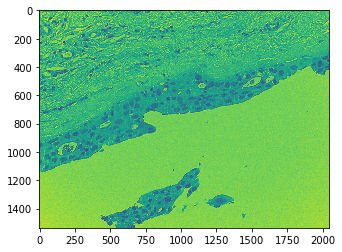

In [154]:
failed_training = save_part_II(insitu_trainlist, 'bach_outputs/train/insitu')

In [155]:
failed_training = save_part_II(invasive_trainlist, 'bach_outputs/train/invasive')

62
0 t59.tif
bach_outputs/train/invasive/watershed_Invasive_t59.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Invasive/t59.tif
1 t58.tif
bach_outputs/train/invasive/watershed_Invasive_t58.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Invasive/t58.tif
2 t60.tif
bach_outputs/train/invasive/watershed_Invasive_t60.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Invasive/t60.tif
3 t48.tif
bach_outputs/train/invasive/watershed_Invasive_t48.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Invasive/t48.tif
4 t49.tif
bach_outputs/train/invasive/watershed_Invasive_t49.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Invasive/t49.tif
5 t61.tif
bach_outputs/train/invasive/watershed_Invasive_t61.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Training_data/Invasive/t61.tif
6 t6.tif
bach

In [156]:
failed_test = save_part_II(testsets[22:], 'bach_outputs/test/')

14
0 33.tif
bach_outputs/test/watershed_Test_data_33.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Test_data/33.tif
1 27.tif
bach_outputs/test/watershed_Test_data_27.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Test_data/27.tif
2 19.tif
bach_outputs/test/watershed_Test_data_19.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Test_data/19.tif
3 31.tif
bach_outputs/test/watershed_Test_data_31.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Test_data/31.tif
4 25.tif
bach_outputs/test/watershed_Test_data_25.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Test_data/25.tif
5 24.tif
bach_outputs/test/watershed_Test_data_24.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Test_data/24.tif
6 30.tif
bach_outputs/test/watershed_Test_data_30.tif
Already saved... skipping ../../data/ICIAR2018_BACH/breasthistology/Test_data/30.tif
7 18.tif
bach_outputs/te

In [220]:
def save_agreement(mydir, Force=False):
    mylist1 = glob(os.path.join(mydir, 'water*npy'))
    mylist2 = glob(os.path.join(mydir, 'db*npy'))
    idlist = [j.split('.npy')[0].split('_')[-1] for j in mylist1]
    
    for i in idlist:
        #Deal with naming convention differences in test set
        if i[0]!='t':
            i='_'+i
        for j1 in mylist1:
            if i == j1.split('.npy')[0][-len(i):]:
                waterpath = j1
                watershed = np.load(waterpath)
        for j2 in mylist2:
            if i == j2.split('.npy')[0][-len(i):]:
                dbpath = j2
                dbscan = np.load(dbpath)
        agreepath = waterpath.replace('watershed', 'agreement')
        if not os.path.exists(agreepath) or Force:
            print('Calculating agreement')
            agree = compare_segmentations(watershed, dbscan, show=True)
            np.save(agreepath, agree)
        else:
            print('already saved %s' % agreepath)
    

In [226]:
save_agreement('bach_outputs/test/')

already saved bach_outputs/test/agreement_Test_data_14.tif.npy
already saved bach_outputs/test/agreement_Test_data_2.tif.npy
already saved bach_outputs/test/agreement_Test_data_32.tif.npy
already saved bach_outputs/test/agreement_Test_data_22.tif.npy
already saved bach_outputs/test/agreement_Test_data_3.tif.npy
already saved bach_outputs/test/agreement_Test_data_23.tif.npy
already saved bach_outputs/test/agreement_Test_data_33.tif.npy
already saved bach_outputs/test/agreement_Test_data_15.tif.npy
already saved bach_outputs/test/agreement_Test_data_1.tif.npy
already saved bach_outputs/test/agreement_Test_data_31.tif.npy
already saved bach_outputs/test/agreement_Test_data_21.tif.npy
already saved bach_outputs/test/agreement_Test_data_8.tif.npy
already saved bach_outputs/test/agreement_Test_data_17.tif.npy
already saved bach_outputs/test/agreement_Test_data_28.tif.npy
already saved bach_outputs/test/agreement_Test_data_9.tif.npy
already saved bach_outputs/test/agreement_Test_data_16.tif.n

In [227]:
save_agreement('bach_outputs/train/Normal/')

already saved bach_outputs/train/Normal/agreement_Normal_t48.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t15.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t23.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t33.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t7.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t41.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t51.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t6.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t32.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t22.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t50.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t40.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t49.tif.npy
already saved bach_outputs/train/Normal/agreement_Normal_t14.tif.npy
already saved bach_outputs/train/Nor

In [228]:
save_agreement('bach_outputs/train/Benign/')

already saved bach_outputs/train/Benign/agreement_Benign_t67.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t15.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t48.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t58.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t4.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t33.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t23.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t51.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t41.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t5.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t22.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t32.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t40.tif.npy
already saved bach_outputs/train/Benign/agreement_Benign_t50.tif.npy
already saved bach_outputs/train/Ben

In [229]:
save_agreement('bach_outputs/train/InSitu/')

already saved bach_outputs/train/InSitu/agreement_InSitu_t12.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t60.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t6.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t46.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t56.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t24.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t34.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t7.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t57.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t47.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t35.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t25.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t13.tif.npy
already saved bach_outputs/train/InSitu/agreement_InSitu_t61.tif.npy
already saved bach_outputs/train/InS

In [230]:
save_agreement('bach_outputs/train/Invasive/')

already saved bach_outputs/train/Invasive/agreement_Invasive_t10.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t3.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t19.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t44.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t54.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t26.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t36.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t18.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t55.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t45.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t37.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t27.tif.npy
already saved bach_outputs/train/Invasive/agreement_Invasive_t11.tif.npy
already saved bach_outputs/train/Invasive/agreement_

NOTE: Need to QC for the white blobs (t32iv, t9iv). 

- If Watershed shape is very weird or if watershed size is large
- look at why hem is staining it? Do we need a consensus on thresholding?